## Importing Packages and Set Up

In [4]:
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors
from matplotlib.mlab import bivariate_normal
from pylab import *
import numpy as np
from scipy import interpolate
from scipy import stats
import csv

import astropy.units as u
from astropy.time import Time, TimeDelta
from astropy.coordinates import SkyCoord, EarthLocation, Angle
from astropy.coordinates import FK5

import detectorgeometry as geom
reload(geom)
from Tau_Exit_Simulator_2 import Tau_Exit_Simulator

## Importing Flight Data

In [2]:
import csv
with open("flight_paths/gpsInfo_ANITA3.csv", 'rb') as csvfile:
    flight_path = csv.reader(csvfile)

# Columns:
    # 0 - Interval Time (Unix Time)
    # 1 - Run
    # 2 - Real Time (Unix Time)
    # 3 - Latitude
    # 4 - Longitude
    # 5 - Altitude
    # 6 - Heading

    flight_path_3=[]
    for row in flight_path:
        if float(row[5])/1000 > 30:
            flight_path_3.append(row)
    
flight_path_3=np.asarray(flight_path_3,dtype=float64)
days_3 = Time(flight_path_3[:,2],format='unix') - Time(min(flight_path_3[:,2]),format='unix')
days_3 = days_3.value

In [3]:
with open('flight_paths/anita1pos.dat', 'rb') as flight_path:
# Columns:
    # 0 - Unix Time
    # 1 - Latitude
    # 2 - Longitude
    # 3 - Altitude
    
    flight_path.readline()
    seen = set()

    time_1=[]
    lat_1=[]
    lon_1=[]
    alt_1=[]

    flight_path_1=[]
    for line in flight_path:
        if line in seen: continue 
        seen.add(line)
        line = line.split()
        if float(line[3])/1000 > 30:
            time_1.append(float(line[0]))
            lat_1.append(float(line[1]))
            lon_1.append(float(line[2]))
            alt_1.append(float(line[3])/1000)

flight_path_1 = [time_1[:546245],lat_1[:546245],lon_1[:546245],alt_1[:546245]] 
days_1 = Time(flight_path_1[0],format='unix') - Time(min(flight_path_1[0]),format='unix')
days_1 = days_1.value


In [4]:
with open('flight_paths/anita4pos.dat', 'rb') as flight_path:
# Columns:
    # 0 - Unix Time
    # 1 - Latitude
    # 2 - Longitude
    # 3 - Altitude
    
    flight_path.readline()
    
    time_4=[]
    lat_4=[]
    lon_4=[]
    alt_4=[]

    flight_path_4=[]
    for line in flight_path:
        line = line.split()
        if float(line[3])/1000 > 30:
            time_4.append(float(line[0]))
            lat_4.append(float(line[1]))
            lon_4.append(float(line[2]))
            alt_4.append(float(line[3])/1000)

flight_path_4 = [time_4,lat_4,lon_4,alt_4]
days_4 = Time(flight_path_4[0],format='unix') - Time(min(flight_path_4[0]),format='unix')
days_4 = days_4.value

## lookup tables for different energies

In [5]:
TES1 = './high_statistics/4.0km_ice_midCS_stdEL/LUT_1e+15_eV.npz'
TES2 = './high_statistics/4.0km_ice_midCS_stdEL/LUT_3e+15_eV.npz'
TES3 = './high_statistics/4.0km_ice_midCS_stdEL/LUT_1e+16_eV.npz'
TES4 = './high_statistics/4.0km_ice_midCS_stdEL/LUT_3e+16_eV.npz'
TES5 = './high_statistics/4.0km_ice_midCS_stdEL/LUT_1e+17_eV.npz'
TES6 = './high_statistics/4.0km_ice_midCS_stdEL/LUT_3e+17_eV.npz'
TES7 = './high_statistics/4.0km_ice_midCS_stdEL/LUT_1e+18_eV.npz'
TES8 = './high_statistics/4.0km_ice_midCS_stdEL/LUT_3e+18_eV.npz'
TES9 = './high_statistics/4.0km_ice_midCS_stdEL/LUT_1e+19_eV.npz'
TES10 = './high_statistics/4.0km_ice_midCS_stdEL/LUT_3e+19_eV.npz'
TES11 = './high_statistics/4.0km_ice_midCS_stdEL/LUT_1e+20_eV.npz'
TES12 = './high_statistics/4.0km_ice_midCS_stdEL/LUT_3e+20_eV.npz'
TES13 = './high_statistics/4.0km_ice_midCS_stdEL/LUT_1e+21_eV.npz'

TESchoices = [TES1,TES2,TES3,TES4,TES5,TES6,TES7,TES8,TES9,TES10,TES11,TES12,TES13]       
energychoices = [15.0,15.5,16.0,16.5,17.0,17.5,18.0,18.5,19.0,19.5,20.0,20.5,21.0]

## Flight Projection Maps

In [6]:
# Setup ANITA Flight Path Data

T_samp = Time('2013-12-11T00:00:00.0') - Time('2013-12-10T00:00:00.0')
T_samp.format = "sec"

A_lat = np.asarray([]) # Earth latitude in degrees
A_long = np.asarray([])# Earth longitude in degrees
A_alt = np.asarray([])
A_ice = np.asarray([])
A_time = np.asarray([])


In [5]:
# Select which Energy to Consider

def TES_data_array(E_nu, E_tau):
    energy_neutrino = E_nu #exponent
    k = energychoices.index(energy_neutrino)
    TES = Tau_Exit_Simulator(TESchoices[k])
    data = load(TESchoices[k])
    exit_angles = data['th_exit_array']

    # Select Exiting Tau Cutoff Energy
    energy_tau = E_tau
    P_exit_arr=np.asarray([])
    P_energy_arr=np.asarray([])

    for j in range(0,len(exit_angles)):
        exit_ang = exit_angles[j]

        try:
            P_exit = TES.P_exit_th_exit(exit_ang+90)
        except: 
            P_exit = 0
        P_exit_arr = np.append(P_exit_arr, P_exit) 

        N = len(data['data_array'][j])
        if N != 0:
            n = sum( 1 if x > energy_tau else 0 for x in data['data_array'][j])
            P_energy = float(n)/float(N)
        else:
            P_energy= 0    
        P_energy_arr = np.append(P_energy_arr, P_energy)

    return exit_angles, P_exit_arr, P_energy_arr

def rho(R,h,theta_E):
    rho_2 = (R+h)**2 + R**2 - 2 * (R+h)*R*np.cos(theta_E)
    rho = np.sqrt(rho_2)
    return rho

def psi(R,h,nadirs):
    psi = pi - np.arcsin(R * np.sin(nadir) / (R+h))
    return psi

In [8]:
# Select which Flight to Map
flight = 1

if flight ==1:
    orbit = Time(max(flight_path_1[0]),format="unix") - Time(min(flight_path_1[0]),format="unix")
    N_sim = orbit/T_samp
    N_sim = int(round(N_sim.value))
    for i in range(0,N_sim):
        A_time_inc = Time(min(flight_path_1[0]),format="unix")+i*T_samp
        A_time  = np.append(A_time, A_time_inc.value)
        A_ice = np.append(A_ice,3.0)
    
    A_lat = np.interp(A_time,flight_path_1[0],flight_path_1[1],0.0,0.0)
    A_long = np.interp(A_time,flight_path_1[0],flight_path_1[2],0.0,0.0)
    A_alt = np.interp(A_time,flight_path_1[0],flight_path_1[3],0.0,0.0)
    T_start = flight_path_1[0][0]

elif flight ==4:
    orbit = Time(max(flight_path_4[0]),format="unix") - Time(min(flight_path_4[0]),format="unix")
    N_sim = orbit/T_samp
    N_sim = int(round(N_sim.value))
    for i in range(0,N_sim):
        A_time_inc = Time(min(flight_path_4[0]),format="unix")+i*T_samp
        A_time  = np.append(A_time, A_time_inc.value)
        A_ice = np.append(A_ice,3.0)
    
    A_lat = np.interp(A_time,flight_path_4[0],flight_path_4[1],0.0,0.0)
    A_long = np.interp(A_time,flight_path_4[0],flight_path_4[2],0.0,0.0)
    A_alt = np.interp(A_time,flight_path_4[0],flight_path_4[3],0.0,0.0)
    T_start = flight_path_4[0][0]
    
elif flight == 3:
    orbit = Time(max(flight_path_3[:,2]),format="unix") - Time(min(flight_path_3[:,2]),format="unix")
    N_sim = orbit/T_samp
    N_sim = int(round(N_sim.value))
    for i in range(0,N_sim):
        A_time_inc = Time(min(flight_path_3[:,2]),format="unix")+i*T_samp
        A_time  = np.append(A_time, A_time_inc.value)
        A_ice = np.append(A_ice,3.0)
    
    A_lat = np.interp(A_time,flight_path_3[:,2],flight_path_3[:,3],0.0,0.0)
    A_long = np.interp(A_time,flight_path_3[:,2],flight_path_3[:,4],0.0,0.0)
    A_alt = np.interp(A_time,flight_path_3[:,2],flight_path_3[:,5]/1000,0.0,0.0)
    T_start = flight_path_3[0,2]
    

In [9]:
h = A_alt 
lat_loc = Angle(A_lat *u.deg)
lon_loc = Angle(A_long * u.deg)
A_loc = EarthLocation(lat = lat_loc,lon = lon_loc, height = h *u.km )

radius = lambda x: np.sqrt(A_loc.geocentric[0][x]**2+A_loc.geocentric[1][x]**2+A_loc.geocentric[2][x]**2)
A_R = radius(range(0,len(A_loc)))

In [10]:
# Map Creation Parameters
sky_bin_dec = np.linspace(-90,90,19) #-90,90,181
sky_bins = np.tile(sky_bin_dec,(360,1))

In [11]:
# Importing Effective Areas for Various Source Angles
with open("eff_area.csv", 'rb') as csvfile:
    areas_ref = csv.reader(csvfile)

    eff_areas=[]
    for row in areas_ref:
        eff_areas.append(row[0])
    
eff_areas=np.asarray(eff_areas,dtype=float64)

## Probability Refinement for various energies

16.0


NameError: global name 'energychoices' is not defined

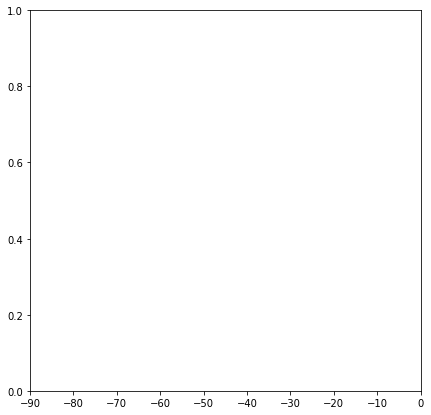

In [8]:
# Select which Energy to Consider
P_exit_arrs = []
Areas = []

fig = plt.figure(figsize=(7,7))
ax = plt.axes()
plt.xlim(-90,0)
plt.ylim(10**(-9),1)
E_tau = 15

for q in [16.0,17.0]:
    print q
    exit_angles, P_exit_arr, P_energy_arr = TES_data_array(q, E_tau)
    # convert from sky bin altitude to source angle
    bin_elev = np.linspace(-90,0,9)
    theta_src = 180+bin_elev - 90
    nadir = radians(theta_src)

    # determine geometric effective area
    A_geom = np.interp(theta_src,np.linspace(0,89,90),eff_areas,0.0,0.0)

    # determine probability associated with exit angle
    P_exit_func = interpolate.interp1d(exit_angles,P_exit_arr, bounds_error=False, fill_value=0)
    P_exit = P_exit_func(bin_elev)* (A_geom>0)

    # determine probability of energy above cutoff
    P_energy_func = interpolate.interp1d(exit_angles,P_energy_arr, bounds_error=False, fill_value=0)
    P_trig = P_energy_func(bin_elev)* (A_geom>0)
    
    # ADD PROBABILITY OF TAU DECAY
    lam = q * 4.9
    psi = psi(A_R_bin,h_bin, nadir)
    theta_E = pi - nadir - psi
    rho = rho(A_R_bin,h_bin, theta_E)

    # # # Geometrical
    P_decay = stats.poisson.cdf(rho,lam)

    # # # Statistical
    
    # ADD PROBABILITY OF RF DETCTION
    # ADD PROBABILITY OF DETECTED SHOWER ENERGY
       
    
    A1 = A_geom
    A2 = P_exit * A_geom
    A3 = P_exit * A_geom * P_trig
    ax.plot(bin_elev,A3)

    
plt.xlabel("Payload Elevation Angle (degrees)", fontsize=18)
plt.ylabel(r'$\langle A \rangle_g \cdot P_{exit}$($E_{\tau} > 10^{14}$ eV)', fontsize=18)
plt.title(r'$\nu_{\tau}$ Exit Probability Distribution by Energy', fontsize=20)
legend = ax.legend([r'$10^{15.0}$ eV',
                   r'$10^{16.0}$ eV',
                   r'$10^{17.5}$ eV',
                   r'$10^{18.0}$ eV',
                   r'$10^{19.5}$ eV',
                   r'$10^{20.0}$ eV',
                   r'$10^{21.0}$ eV'],title=r'$E_{\nu_{\tau}}$', fontsize=12)
plt.setp(legend.get_title(),fontsize='x-large')
plt.semilogy()

## ANIMATION determining effective area for each bin of the sky map

In [ ]:
# determining effective area for each bin of the sky map
sky_maps_frames_sep=[]
sky_maps_frames_total=[]

sky_map_total = np.asarray([[0 for x in range(19)] for y in range(360)],dtype=float64) #181
for k in range(1,2):
    
    sky_map_b = np.asarray([[0 for x in range(19)] for y in range(360)],dtype=float64 ) #181
    
    # determine ANITA approximate position for that time bin
    A_time_bin = A_time[k]
    A_lat_bin = A_lat[k]
    A_lon_bin = A_long[k]
    A_alt_bin = A_alt[k]
    A_ice_bin = A_ice[k]
    A_R_bin = A_R[k].value
    print A_lat_bin, A_lon_bin, A_alt_bin

    h_bin = max(35,A_alt_bin)
    print k, h_bin, A_R_bin
    lat_loc_bin = Angle(A_lat_bin *u.deg)
    lon_loc_bin = Angle(A_lon_bin * u.deg)
    A_loc_bin = EarthLocation(lat = lat_loc_bin,lon = lon_loc_bin, height = h_bin *u.km )
            
    for i in range(0,1): #0, 360
        # print i
        bin_ra = Angle(i * u.deg)
        bin_dec = Angle(sky_bins[i] * u.deg)
    
        # determine the altitude and azimuth of the sky map bin from ANITA's point of view
        sky_bin_loc = SkyCoord(ra = bin_ra, dec = bin_dec, frame = 'icrs', obstime = Time(A_time_bin,format="unix"), location = A_loc_bin)
        sky_bin_alt_az = sky_bin_loc.transform_to('altaz')
        sky_bin_alt = sky_bin_alt_az.alt

        # convert from sky bin altitude to source angle
        bin_elev = sky_bin_alt.value
        theta_src = 180+bin_elev - 90
        nadir = radians(theta_src)
        
        # determine geometric effective area
        A_geom = np.interp(theta_src,np.linspace(0,89,90),eff_areas,0.0,0.0)

        # determine probability associated with exit angle
        P_exit_func = interpolate.interp1d(exit_angles,P_exit_arr, bounds_error=False, fill_value=0)
        P_exit = P_exit_func(bin_elev)* (A_geom>0)

        # determine probability of energy above cutoff
        P_energy_func = interpolate.interp1d(exit_angles,P_energy_arr, bounds_error=False, fill_value=0)
        P_trig = P_energy_func(bin_elev)* (A_geom>0)
        

        A1 = A_geom
        A2 = P_exit * A_geom
        A3 = P_exit * A_geom * P_trig
        
        sky_map_b[i] = np.asarray(A1,dtype=float64)  
    
    sky_map_total = sky_map_total+sky_map_b
    sky_maps_frames_sep.append(sky_map_b)
    
    sky_map_mean = sky_map_total #/float(k+1)
    sky_maps_frames_total.append(sky_map_mean)

In [ ]:
# Making Sky Map for each Time Sample
for k in range(0,1): #0, N_sim
    fig = plt.figure(figsize=(10,10))

    left = 0
    right = 360
    bottom = -90
    top = 90
    extent = [left, right, bottom, top]
    plt.imshow(np.flip(np.transpose(sky_maps_frames_sep[k]),0), extent = extent, norm=matplotlib.colors.LogNorm())
    plt.text(370,20,'Log Color Scale',rotation=90,fontsize=12)
    plt.colorbar(shrink=0.5)
    plt.clim(5*10**(-9), 10**(-3))
    plt.ylabel("Declination (degrees)", fontsize=18)
    plt.xlabel("Right Ascension (degrees)", fontsize=18)
    plt.title("ANITA " +str(flight)+' 10e'+str(energy_neutrino)+" eV Effective Area Sky Projection", fontsize=20)
    plt.text(0, -140, "Sample Time = "+str(T_samp.value/60)+" min")
    filename = "animations/bin_sep"+str(k)+".png"
    plt.savefig(filename)
    plt.show()




In [ ]:
# Making Cumulative Sky Map
for k in range(0,N_sim): #0, N_sim
    fig = plt.figure(figsize=(10,10))
    left = 0
    right = 360
    bottom = -90
    top = 90
    extent = [left, right, bottom, top]
    plt.imshow(np.flip(np.transpose(sky_maps_frames_total[k]),0), extent = extent, norm=matplotlib.colors.LogNorm())
    plt.text(370,20,'Log Color Scale',rotation=90,fontsize=12)
    plt.colorbar(shrink=0.5)
    plt.clim(5*10**(-9), 10**(-3));
    plt.text(0, -140, "Sample Time = "+str(T_samp.value/60)+" min")
    plt.ylabel("Declination (degrees)", fontsize=18)
    plt.xlabel("Right Ascension (degrees)", fontsize=18)
    plt.title("ANITA " +str(flight)+' 10e'+str(energy_neutrino)+" eV Effective Area Sky Projection", fontsize=20)
    filename = "animations/bin_tot"+str(k)+".png"
    plt.savefig(filename)
    #plt.show()

In [ ]:
# Making Movie
import imageio
images = []
for k in range(0,N_sim):
    filename = "animations/bin_sep"+str(k)+".png"
    images.append(imageio.imread(filename))
imageio.mimsave('animations/ANITA_'+str(flight)+'_movie_sep_'+str(T_samp.value/60)+'_10e'+str(energy_neutrino)+'.gif', images)

images = []
for k in range(0,N_sim):
    filename = "animations/bin_tot"+str(k)+".png"
    images.append(imageio.imread(filename))
imageio.mimsave('animations/ANITA_'+str(flight)+'_movie_tot_'+str(T_samp.value/60)+'_10e'+str(energy_neutrino)+'.gif', images)

## Probability refinement effect

In [ ]:
fig = plt.figure(figsize=(7,7))
ax = plt.axes()
#plt.xlim(-90,0)
#plt.ylim(10**(-10),1)
k=1

# convert from sky bin altitude to source angle
bin_elev = np.linspace(-90,0,90)
theta_src = 180+bin_elev - 90
nadir = radians(theta_src)

# determine geometric effective area
A_geom = np.interp(theta_src,np.linspace(0,89,90),eff_areas,0.0,0.0)

# determine probability associated with exit angle
P_exit_func = interpolate.interp1d(exit_angles,P_exit_arr, bounds_error=False, fill_value=0)
P_exit = P_exit_func(bin_elev)* (A_geom>0)

# determine probability of energy above cutoff
P_energy_func = interpolate.interp1d(exit_angles,P_energy_arr, bounds_error=False, fill_value=0)
P_trig = P_energy_func(bin_elev)* (A_geom>0)

# ADD PROBABILITY OF TAU DECAY

# ADD PROBABILITY OF RF DETECTION

A1 = A_geom
A2 = P_exit * A_geom
A3 = P_exit * A_geom * P_trig
ax.plot(bin_elev,A1)
ax.plot(bin_elev,A2)
ax.plot(bin_elev,A3)
plt.xlabel("Payload Elevation Angle (degrees)", fontsize=18)
plt.ylabel("Exit Probability", fontsize=18)
plt.title(r'$\nu_{\tau}$ Exit Probability Distribution Refinement', fontsize=20)
legend = ax.legend([r'$\langle A \rangle_g$',
                   r'$\langle A \rangle_g \cdot P_{exit}$',
                   r'$\langle A \rangle_g \cdot P_{exit} \cdot P_{trig}$'], fontsize=12, loc=8)
plt.semilogy()